In [22]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict
import time


class DailyPlanState(TypedDict):
    Name: str
    breakfast: bool
    lunch: bool
    snacks: bool
    dinner: bool


def step1(daily_plan_state: DailyPlanState):
    print(f"***** {daily_plan_state['Name']} : Having breakfast ******")
    time.sleep(10)
    print(f"***** {daily_plan_state['Name']} : Done with breakfast ******")
    return {"breakfast": True}


def step2(daily_plan_state: DailyPlanState):
    print(f"***** {daily_plan_state['Name']} : Having lunch ******")
    time.sleep(10)
    print(f"***** {daily_plan_state['Name']} : Done with lunch ******")
    return {"lunch": True}


def step3(daily_plan_state: DailyPlanState):
    print(f"***** {daily_plan_state['Name']} : Having snacks ******")
    time.sleep(10)
    print(f"***** {daily_plan_state['Name']} : Done with snacks ******")
    return {"snacks": True}


def step4(daily_plan_state: DailyPlanState):
    print(f"***** {daily_plan_state['Name']} : Having dinner ******")
    time.sleep(10)
    print(f"***** {daily_plan_state['Name']} : Done with dinner ******")
    return {"dinner": True}


daily_plan_grpah_builder = StateGraph(state_schema=DailyPlanState)
daily_plan_memeory_checkpoint = MemorySaver()
daily_plan_grpah_builder.add_node("breakfast", step1)
daily_plan_grpah_builder.add_node("lunch", step2)
daily_plan_grpah_builder.add_node("snaks", step3)
daily_plan_grpah_builder.add_node("dinner", step4)
daily_plan_grpah_builder.add_edge(START, "breakfast")
daily_plan_grpah_builder.add_edge("breakfast", "lunch")
daily_plan_grpah_builder.add_edge("lunch", "snaks")
daily_plan_grpah_builder.add_edge("snaks", "dinner")
daily_plan_grpah_builder.add_edge("dinner", END)
daily_plan_graph = daily_plan_grpah_builder.compile(
    checkpointer=daily_plan_memeory_checkpoint
)
config = {"configurable": {"thread_id": "Biman Giri"}}

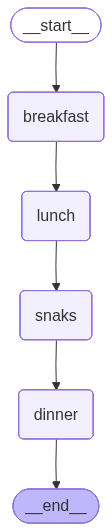

In [23]:
daily_plan_graph

In [24]:
try:
    print("***Running graph***")
    daily_plan_graph.invoke({"Name": "Biman"}, config=config)
except KeyboardInterrupt:
    print("Interrupted by user")

***Running graph***
***** Biman : Having breakfast ******
***** Biman : Done with breakfast ******
***** Biman : Having lunch ******
***** Biman : Done with lunch ******
***** Biman : Having snacks ******
Interrupted by user


In [ ]:
for state in list(daily_plan_graph.get_state_history(config=config)):
    print(state.values)
    print("=" * 60)

{'Name': 'Biman', 'breakfast': True}


In [ ]:
##### this will resume the graph execution where it left off

try:
    print("***Running graph***")
    daily_plan_graph.invoke(None, config=config)
except KeyboardInterrupt:
    print("Interrupted by user")

***Running graph***


In [31]:
for state in list(daily_plan_graph.get_state_history(config=config)):
    print(state.values)
    print("=" * 60)

{'Name': 'Biman', 'breakfast': True, 'lunch': True}
{'Name': 'Biman', 'breakfast': True}
{'Name': 'Biman'}
{}


In [35]:
#### how to go back to the specific steps
list(daily_plan_graph.get_state_history(config=config))

[StateSnapshot(values={'Name': 'Biman', 'breakfast': True, 'lunch': True, 'snacks': True, 'dinner': True}, next=(), config={'configurable': {'thread_id': 'Biman Giri', 'checkpoint_ns': '', 'checkpoint_id': '1f0e576f-17ff-6ac2-8004-4893195f133b'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-12-30T11:59:06.908303+00:00', parent_config={'configurable': {'thread_id': 'Biman Giri', 'checkpoint_ns': '', 'checkpoint_id': '1f0e5769-5f4b-6e7c-8003-178af80cfa3b'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'Name': 'Biman', 'breakfast': True, 'lunch': True, 'snacks': True, 'dinner': True}, next=(), config={'configurable': {'thread_id': 'Biman Giri', 'checkpoint_ns': '', 'checkpoint_id': '1f0e5769-bec4-603e-8004-cb29fe7f1b37'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-12-30T11:56:43.333802+00:00', parent_config={'configurable': {'thread_id': 'Biman Giri', 'checkpoint_ns': '', 'checkpoint_id': '1f0e5769-5f4b-6e7c-8003-178af80cfa3b'

Even though I have interupted while having snacks thats why if I will do resume the flow will start from the snacks node, but as I have given specific checkpoint , like I wanted to start the flow while having the lunch , then the flow will start from while having the lunch not like while having snacks

In [ ]:
new_config = {
    "configurable": {
        "thread_id": "Biman Giri",
        "checkpoint_id": "1f0e5757-a34f-63f6-8001-9b3ed83d9817",  # this is the checkpoint id of Lunch node
    }
}
daily_plan_graph.invoke(None, config=new_config)

***** Biman : Having lunch ******
***** Biman : Done with lunch ******
***** Biman : Having snacks ******
***** Biman : Done with snacks ******
***** Biman : Having dinner ******
***** Biman : Done with dinner ******


{'Name': 'Biman',
 'breakfast': True,
 'lunch': True,
 'snacks': True,
 'dinner': True}

In [ ]:
new_config = {
    "configurable": {
        "thread_id": "Biman Giri",
        "checkpoint_id": "1f0e5769-5f4b-6e7c-8003-178af80cfa3b",  # this is the checkpoint id of dinner node
    }
}
daily_plan_graph.invoke(None, config=new_config)

***** Biman : Having dinner ******
***** Biman : Done with dinner ******


{'Name': 'Biman',
 'breakfast': True,
 'lunch': True,
 'snacks': True,
 'dinner': True}

In Human in the loop : graph execute and take in the human input and then continue to execute. But the issue is if the human take more time let say more than a day or week, then in that case the graph will not keep on running. Here the langgraph design intelligence come into the picture where as soon as it see that in the graph the human input is required , the graph interrupted and stop it. As soon as it get the human input it again resume the execution. this is also benifit of the persistance.
